# APOSEMAT IOT-23

### Carga y limpieza

In [2]:
from DataLoader import DataLoader
from DataProcessor import DataProcessor
import pandas as pd

Loader = DataLoader()

In [3]:
# Load the Zeek connection log with labels
df1 = Loader.load_dataset(file_path="../data/1conn.log.labeled", file_type="zeek")
df2 = Loader.load_dataset(file_path="../data/3conn.log.labeled", file_type="zeek")

df = pd.concat([df1, df2], ignore_index=True)

In [3]:
# Display the first few rows of the DataFrame
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,NaN,2.999051,0,...,<NA>,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,NaN,NaN,<NA>,...,<NA>,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,<NA>,...,<NA>,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,NaN,2.998796,0,...,<NA>,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,<NA>,...,<NA>,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


In [4]:
# Observe the DataFrame structure and types to check for any inconsistencies
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164851 entries, 0 to 1164850
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ts              1164851 non-null  float64
 1   uid             1164851 non-null  object 
 2   id.orig_h       1164851 non-null  object 
 3   id.orig_p       1164851 non-null  Int64  
 4   id.resp_h       1164851 non-null  object 
 5   id.resp_p       1164851 non-null  Int64  
 6   proto           1164851 non-null  object 
 7   service         9149 non-null     object 
 8   duration        294607 non-null   float64
 9   orig_bytes      294607 non-null   Int64  
 10  resp_bytes      294607 non-null   Int64  
 11  conn_state      1164851 non-null  object 
 12  local_orig      0 non-null        boolean
 13  local_resp      0 non-null        boolean
 14  missed_bytes    1164851 non-null  Int64  
 15  history         1146223 non-null  object 
 16  orig_pkts       1164851 non-null  In

In [5]:
# Clean the dataset using the DataLoader's clean_dataset method that removes duplicates
df = Loader.clean_dataset(df)

2025-09-04 14:05:17,148 - INFO - Dataset cleaned successfully. 0 rows have been removed.


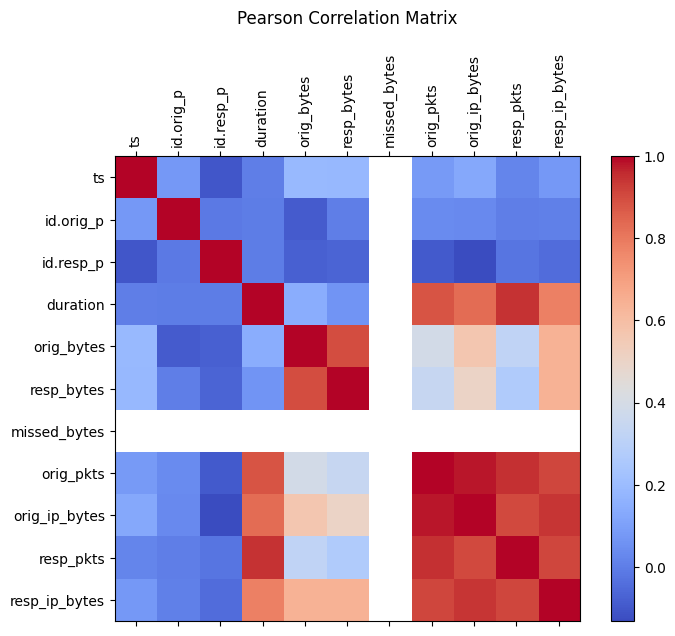

In [5]:
import matplotlib.pyplot as plt
import numpy as np
df_num = df.select_dtypes(include=[np.number])
corr = df_num.corr(method='pearson')

plt.figure(figsize=(8,6))
plt.matshow(corr, cmap="coolwarm", fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Pearson Correlation Matrix", pad=20)
plt.show()

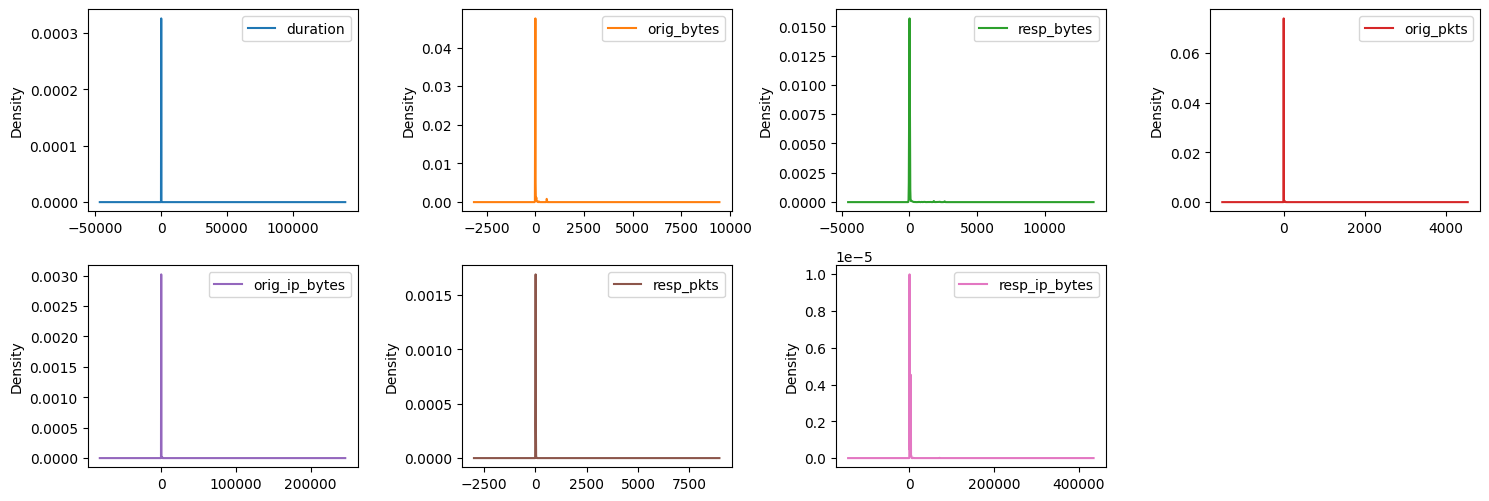

In [16]:
df_num = df_num.loc[:, df_num.std() > 0]
df_num = df_num.drop(columns=['ts', 'id.orig_p', 'id.resp_p'], errors='ignore')
df_num.plot(kind="density", subplots=True, layout=(4, 4), figsize=(15, 10), sharex=False)
plt.tight_layout()
plt.show()

In [6]:
# Drop columns that could provide artificial patterns and prepare the features and labels
drop_cols = ["uid", "id.orig_h", "id.resp_h", "id.orig_p", "id.resp_p",
    "tunnel_parents", "service", "history", "local_orig", "local_resp", "ts"
]

X = df.drop(columns=drop_cols + ["label","detailed-label"])
y = df["label"].map({"Benign":0, "Malicious":1}).astype("Int64")

In [7]:
# Check the first few rows of the features DataFrame
X.head()

,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,tcp,2.999051,0,0,S0,0,3,180,0,0
1,tcp,NaN,<NA>,<NA>,S0,0,1,60,0,0
2,tcp,NaN,<NA>,<NA>,S0,0,1,60,0,0
3,tcp,2.998796,0,0,S0,0,3,180,0,0
4,tcp,NaN,<NA>,<NA>,S0,0,1,60,0,0


In [8]:
# Check the first few rows of the labels Series
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: Int64

In [9]:
# Look at the distribution of the labels to check for class imbalance
print(y.value_counts(normalize=True))

label
1    0.593243
0    0.406757
Name: proportion, dtype: Float64


### Nested Stratified KFold with SearchGrid

In [10]:
# Declare the DataProcessor instance
Processor = DataProcessor()

# Get numerical and categorical columns from the DataFrame manually
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [11]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import kruskal
import numpy as np

# Define the Kruskal-Wallis score function for feature selection
# This function computes the Kruskal-Wallis H statistic for each feature
def kruskal_wallis_score(X, y):
    scores = []
    pvalues = []
    for i in range(X.shape[1]):
        groups = [X[y == cls, i] for cls in np.unique(y)]
        try:
            stat, p = kruskal(*groups)
        except ValueError:
            stat, p = 0, 1
        scores.append(stat)
        pvalues.append(p)
    return np.array(scores), np.array(pvalues)

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

In [13]:
seeds = [0, 21, 42]

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Define the outer and inner cross-validation strategies
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier  
from sklearn.metrics import matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import time, sys
import joblib, os
from sklearn.base import clone
import pickle

# Define the feature selectors
feature_selectors = {
    "anova": SelectKBest(score_func=f_classif),
    "kruskal": SelectKBest(score_func=kruskal_wallis_score)
}

from sklearn.model_selection import RandomizedSearchCV

models = {
    "XGBoost": {
        "estimator": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "param_grid": {
            "select__k": [5, 15],
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [5, None],
            "clf__learning_rate": [0.05, 0.1]
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(),
        "param_grid": {
            "select__k": [5, 15],
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [None, 10]
        }
    },
    "MLPClassifier": {
        "estimator": MLPClassifier(max_iter=300, random_state=42),
        "param_grid": {
            "select__k": [5, 15],
            "clf__hidden_layer_sizes": [(50,), (100,)],
            "clf__activation": ["relu"],
            "clf__alpha": [0.0001, 0.001]
        }
    }
}

results = []
preds = {}
for selector in feature_selectors.keys():
    print(f"\nTesting Feature Selector: {selector}...")
    selector_instance = feature_selectors[selector]

    for model, configuration in models.items():
        print(f"\n Testing Model: {model}...")
        estimator = configuration["estimator"]
        param_grid = configuration["param_grid"]

        outer_scores = {"f1": [], "roc_auc": [], "auprc": [], "mcc": [], 
                        "brier": [], "fnr": [], "training_time": [], "size": []}
        best_params_folds, best_features_folds = [], []
        confusion_matrixes, classification_reports = [], []

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipe = Pipeline([
                ("pre", DataProcessor(num_cols, cat_cols)),
                ("select", clone(selector_instance)),
                ("clf", estimator)
            ])

            search = RandomizedSearchCV(
                pipe,
                param_distributions=param_grid,
                n_iter=8,
                scoring="f1",
                cv=inner_cv,   
                n_jobs=-1,
                random_state=42
            )

            start = time.perf_counter()
            search.fit(X_train, y_train)
            train_time = time.perf_counter() - start

            best_model = search.best_estimator_
            best_params_folds.append(search.best_params_)

            y_pred = best_model.predict(X_test)
            if f"{model}_{selector}" not in preds:
                preds[f"{model}_{selector}"] = np.zeros_like(y)

            preds[f"{model}_{selector}"][test_idx] = y_pred

            y_proba = best_model.predict_proba(X_test)[:, 1]

            # Metrics
            outer_scores["f1"].append(f1_score(y_test, y_pred))
            outer_scores["roc_auc"].append(roc_auc_score(y_test, y_proba))
            outer_scores["auprc"].append(average_precision_score(y_test, y_proba))
            outer_scores["mcc"].append(matthews_corrcoef(y_test, y_pred))
            outer_scores["brier"].append(brier_score_loss(y_test, y_proba))
            outer_scores["training_time"].append(train_time)

            # Best Features
            select_step = best_model.named_steps["select"]
            feature_names = best_model.named_steps["pre"].get_feature_names_out()
            selected_mask = select_step.get_support()
            selected_features = feature_names[selected_mask]
            best_features_folds.append(list(selected_features))

            # Confusion matrix & report
            cm = confusion_matrix(y_test, y_pred, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            outer_scores["fnr"].append(fnr)
            confusion_matrixes.append(cm)

            report = classification_report(
                y_test, y_pred,
                target_names=["Benigno (0)", "Malicioso (1)"],
                output_dict=True
            )
            classification_reports.append(report)

            size_bytes = sys.getsizeof(pickle.dumps(best_model))
            outer_scores["size"].append(size_bytes / 1024)

        results.append({
            "Modelo": f"{model}_{selector}",
            "F1": f"{np.mean(outer_scores['f1']):.3f} ± {np.std(outer_scores['f1']):.3f}",
            "ROC-AUC": f"{np.mean(outer_scores['roc_auc']):.3f} ± {np.std(outer_scores['roc_auc']):.3f}",
            "AUPRC": f"{np.mean(outer_scores['auprc']):.3f} ± {np.std(outer_scores['auprc']):.3f}",
            "MCC": f"{np.mean(outer_scores['mcc']):.3f} ± {np.std(outer_scores['mcc']):.3f}",
            "Brier": f"{np.mean(outer_scores['brier']):.3f} ± {np.std(outer_scores['brier']):.3f}",
            "FNR": f"{np.mean(outer_scores['fnr']):.3f} ± {np.std(outer_scores['fnr']):.3f}",
            "TrainTime (s)": f"{np.mean(outer_scores['training_time']):.2f} ± {np.std(outer_scores['training_time']):.2f}",
            "ModelSize (KB)": f"{np.mean(outer_scores['size']):.1f} ± {np.std(outer_scores['size']):.1f}",
            "FeatureSelector": selector,
            "BestParams_por_fold": best_params_folds,
            "BestFeatures_por_fold": best_features_folds,
            "ConfusionMatrix_por_fold": confusion_matrixes,
            "ClassificationReport_por_fold": classification_reports
        })

df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results[["Modelo", "F1", "ROC-AUC", "AUPRC", "MCC", "Brier", "FNR", "TrainTime (s)", "ModelSize (KB)"]])

for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    selector = row["FeatureSelector"]
    features_folds = row["BestFeatures_por_fold"]

    all_feats = [feat for fold_feats in features_folds for feat in fold_feats]
    feat_counts = pd.Series(all_feats).value_counts()

    print(f"\n{modelo} ({selector})")
    print("Features más seleccionadas:")
    print(feat_counts)






Starting experiments with seed: 0

Testing Feature Selector: anova...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...

Testing Feature Selector: kruskal...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...



Starting experiments with seed: 21

Testing Feature Selector: anova...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...

Testing Feature Selector: kruskal...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...



Starting experiments with seed: 42

Testing Feature Selector: anova...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...

Testing Feature Selector: kruskal...

 Testing Model: XGBoost...

 Testing Model: RandomForest...

 Testing Model: MLPClassifier...


TypeError: unhashable type: 'Series'

In [ ]:
print("\nFinal Results:")
print(df_results[["Modelo", "F1", "ROC-AUC", "AUPRC", "MCC", "Brier", "FNR", "TrainTime (s)", "ModelSize (KB)"]])

In [ ]:
for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    selector = row["FeatureSelector"]
    features_folds = row["BestFeatures_por_fold"]

    all_feats = [feat for fold_feats in features_folds for feat in fold_feats]
    feat_counts = pd.Series(all_feats).value_counts()

    print(f"\n{modelo} ({selector})")
    print("Features más seleccionadas:")
    print(feat_counts)

In [ ]:
for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    best_params_list = row["BestParams_por_fold"]

    params_tuples = [tuple(sorted(d.items())) for d in best_params_list]
    params_counts = pd.Series(params_tuples).value_counts()

    print(f"\n{modelo}")


    best_overall = dict(params_counts.index[0])
    print("=> Mejor configuración final:", best_overall)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("pre", DataProcessor(num_cols, cat_cols)),
    ("clf", LogisticRegression(max_iter=500, random_state=42))
])

param_dist = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=4,
                            scoring="f1", cv=cv, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

print("Best parameters:", search.best_params_)
print("Confusion Matrix:\n", cm)
print(f"F1: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"AUPRC: {average_precision_score(y_test, y_proba):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
print(f"Brier: {brier_score_loss(y_test, y_proba):.3f}")
print(f"FNR: {fnr:.3f}")
print("Classification Report:\n", classification_report(
    y_test, y_pred, target_names=["Benigno (0)", "Malicioso (1)"]
))

In [ ]:
X.drop(columns=["conn_state", "missed_bytes", "proto"], inplace=True)
# Drop conn state, missed bytes and proto
cat_cols.remove("conn_state")
num_cols.remove("missed_bytes")
cat_cols.remove("proto")

In [ ]:
X.head()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier  
from sklearn.metrics import matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report
import time, sys
import joblib, os
from sklearn.base import clone
import pickle

# Define the feature selectors
feature_selectors = {
    "anova": SelectKBest(score_func=f_classif),
    "kruskal": SelectKBest(score_func=kruskal_wallis_score)
}

from sklearn.model_selection import RandomizedSearchCV

models = {
    "XGBoost": {
        "estimator": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "param_grid": {
            "select__k": [5, 15],
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [5, None],
            "clf__learning_rate": [0.05, 0.1]
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(),
        "param_grid": {
            "select__k": [5, 15],
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [None, 10]
        }
    },
    "MLPClassifier": {
        "estimator": MLPClassifier(max_iter=300, random_state=42),
        "param_grid": {
            "select__k": [5, 15],
            "clf__hidden_layer_sizes": [(50,), (100,)],
            "clf__activation": ["relu"],
            "clf__alpha": [0.0001, 0.001]
        }
    }
}

results = []
preds = {}
for selector in feature_selectors.keys():
    print(f"\nTesting Feature Selector: {selector}...")
    selector_instance = feature_selectors[selector]

    for model, configuration in models.items():
        print(f"\n Testing Model: {model}...")
        estimator = configuration["estimator"]
        param_grid = configuration["param_grid"]

        outer_scores = {"f1": [], "roc_auc": [], "auprc": [], "mcc": [], 
                        "brier": [], "fnr": [], "training_time": [], "size": []}
        best_params_folds, best_features_folds = [], []
        confusion_matrixes, classification_reports = [], []

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipe = Pipeline([
                ("pre", DataProcessor(num_cols, cat_cols)),
                ("select", clone(selector_instance)),
                ("clf", estimator)
            ])

            search = RandomizedSearchCV(
                pipe,
                param_distributions=param_grid,
                n_iter=8,                  # menos combinaciones
                scoring="f1",
                cv=inner_cv,               # inner_cv reducido (3)
                n_jobs=-1,
                random_state=42
            )

            start = time.perf_counter()
            search.fit(X_train, y_train)
            train_time = time.perf_counter() - start

            best_model = search.best_estimator_
            best_params_folds.append(search.best_params_)

            y_pred = best_model.predict(X_test)
            if f"{model}_{selector}" not in preds:
                preds[f"{model}_{selector}"] = np.zeros_like(y)

            preds[f"{model}_{selector}"][test_idx] = y_pred

            y_proba = best_model.predict_proba(X_test)[:, 1]

            # Metrics
            outer_scores["f1"].append(f1_score(y_test, y_pred))
            outer_scores["roc_auc"].append(roc_auc_score(y_test, y_proba))
            outer_scores["auprc"].append(average_precision_score(y_test, y_proba))
            outer_scores["mcc"].append(matthews_corrcoef(y_test, y_pred))
            outer_scores["brier"].append(brier_score_loss(y_test, y_proba))
            outer_scores["training_time"].append(train_time)

            # Best Features
            select_step = best_model.named_steps["select"]
            feature_names = best_model.named_steps["pre"].get_feature_names_out()
            selected_mask = select_step.get_support()
            selected_features = feature_names[selected_mask]
            best_features_folds.append(list(selected_features))

            # Confusion matrix & report
            cm = confusion_matrix(y_test, y_pred, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            outer_scores["fnr"].append(fnr)
            confusion_matrixes.append(cm)

            report = classification_report(
                y_test, y_pred,
                target_names=["Benigno (0)", "Malicioso (1)"],
                output_dict=True
            )
            classification_reports.append(report)

            size_bytes = sys.getsizeof(pickle.dumps(best_model))
            outer_scores["size"].append(size_bytes / 1024)

        results.append({
            "Modelo": f"{model}_{selector}",
            "F1": f"{np.mean(outer_scores['f1']):.3f} ± {np.std(outer_scores['f1']):.3f}",
            "ROC-AUC": f"{np.mean(outer_scores['roc_auc']):.3f} ± {np.std(outer_scores['roc_auc']):.3f}",
            "AUPRC": f"{np.mean(outer_scores['auprc']):.3f} ± {np.std(outer_scores['auprc']):.3f}",
            "MCC": f"{np.mean(outer_scores['mcc']):.3f} ± {np.std(outer_scores['mcc']):.3f}",
            "Brier": f"{np.mean(outer_scores['brier']):.3f} ± {np.std(outer_scores['brier']):.3f}",
            "FNR": f"{np.mean(outer_scores['fnr']):.3f} ± {np.std(outer_scores['fnr']):.3f}",
            "TrainTime (s)": f"{np.mean(outer_scores['training_time']):.2f} ± {np.std(outer_scores['training_time']):.2f}",
            "ModelSize (KB)": f"{np.mean(outer_scores['size']):.1f} ± {np.std(outer_scores['size']):.1f}",
            "FeatureSelector": selector,
            "BestParams_por_fold": best_params_folds,
            "BestFeatures_por_fold": best_features_folds,
            "ConfusionMatrix_por_fold": confusion_matrixes,
            "ClassificationReport_por_fold": classification_reports
        })

df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results[["Modelo", "F1", "ROC-AUC", "AUPRC", "MCC", "Brier", "FNR", "TrainTime (s)", "ModelSize (KB)"]])

for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    selector = row["FeatureSelector"]
    features_folds = row["BestFeatures_por_fold"]

    all_feats = [feat for fold_feats in features_folds for feat in fold_feats]
    feat_counts = pd.Series(all_feats).value_counts()

    print(f"\n{modelo} ({selector})")
    print("Features más seleccionadas:")
    print(feat_counts)



In [ ]:
for _, row in df_results.iterrows():
    modelo = row["Modelo"]
    selector = row["FeatureSelector"]
    features_folds = row["BestFeatures_por_fold"]

    all_feats = [feat for fold_feats in features_folds for feat in fold_feats]
    feat_counts = pd.Series(all_feats).value_counts()

    print(f"\n{modelo} ({selector})")
    print("Features más seleccionadas:")
    print(feat_counts)

In [ ]:
print(df_results[["Modelo", "F1", "ROC-AUC", "AUPRC", "MCC", "Brier", "FNR", "TrainTime (s)", "ModelSize (KB)"]])

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.model_selection import cross_val_predict

def mcnemar_test(y_true, preds1, preds2):
    b = np.sum((preds1 == y_true) & (preds2 != y_true))
    c = np.sum((preds1 != y_true) & (preds2 == y_true))
    table = [[0, b], [c, 0]]
    result = mcnemar(table, exact=False, correction=True)
    return result.statistic, result.pvalue


pairs = [
    ("XGBoost_anova", "RandomForest_anova"),
    ("XGBoost_anova", "MLPClassifier_anova"),
    ("RandomForest_anova", "MLPClassifier_anova"),
    ("XGBoost_kruskal", "RandomForest_kruskal"),
    ("XGBoost_kruskal", "MLPClassifier_kruskal"),
    ("RandomForest_kruskal", "MLPClassifier_kruskal")
]

rows = []
for m1, m2 in pairs:
    stat, pval = mcnemar_test(y, preds[m1], preds[m2])
    rows.append({"Modelo 1": m1, "Modelo 2": m2,
                 "Estadístico": f"{stat:.3f}", "p-valor": f"{pval:.5f}"})

df_mcnemar = pd.DataFrame(rows)
print(df_mcnemar)

